In [1]:
%pylab inline
import pandas as pd
import torch
from pyro.contrib.brm import brm
from pyro.contrib.brm.priors import PriorEdit, Prior, prior
from pyro.contrib.brm.fit import print_marginals, print_marginals_simple, print_model
from pyro.contrib.brm.family import getfamily, Delta, Type
from pyro.contrib.brm.model import parameter_names

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('EfronMorrisBB.txt', sep='\t')
df['LastName'] = df['LastName'].astype('category')
del df['FirstName']

In [3]:
df.head()

,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
0,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Berry,45,14,0.311,418,0.2727,463,128,0.276


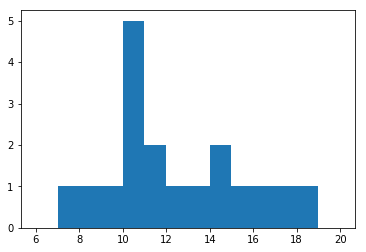

In [4]:
hist(df['Hits'], bins=range(6, 21));

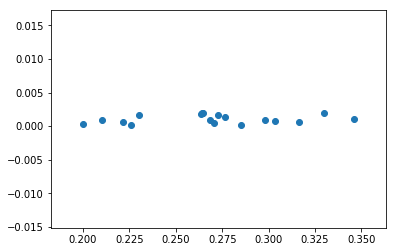

In [5]:
scatter(df['RemainingAverage'], np.random.rand(18)*0.002);

To use the binomial family as the response distribution we need to give a value for its number of trials parameter. In brms this is achieved by writing something like `Hits | trials(...)` on the left hand side of the formula. brmp doesn't support this, but we can achieve the same thing by specifying a delta prior on the number of trials parameter. (This only works for the simple case where the number of trials is the same for every row of the data frame.)

In [6]:
fit = brm('Hits ~ 1 + (1 | LastName)', df, getfamily('Binomial'), [
    PriorEdit(('b', 'intercept'), prior('Normal', [0., 1.5])),
    PriorEdit(('resp', 'num_trials'), Prior(Delta(Type.non_neg_int), [45.])),
], iter=1000, warmup=100)

Sample: 100%|██████████| 1100/1100 [00:55<00:00, 19.68it/s, step size=2.96e-01, acc. rate=0.979]


In [7]:
print_marginals(fit)

                                   mean    sd
                     b_intercept  -1.02  0.10
  r_LastName[Alvarado,intercept]   0.01  0.16
     r_LastName[Alvis,intercept]  -0.14  0.20
     r_LastName[Berry,intercept]   0.05  0.17
r_LastName[Campaneris,intercept]  -0.07  0.16
  r_LastName[Clemente,intercept]   0.16  0.20
    r_LastName[Howard,intercept]   0.10  0.19
 r_LastName[Johnstone,intercept]   0.08  0.17
 r_LastName[Kessinger,intercept]   0.02  0.16
    r_LastName[Munson,intercept]  -0.09  0.17
r_LastName[Petrocelli,intercept]  -0.04  0.17
  r_LastName[Robinson,intercept]   0.12  0.19
 r_LastName[Rodriguez,intercept]  -0.06  0.18
     r_LastName[Santo,intercept]  -0.02  0.17
     r_LastName[Scott,intercept]  -0.04  0.16
   r_LastName[Spencer,intercept]   0.06  0.17
   r_LastName[Swaboda,intercept]  -0.02  0.16
     r_LastName[Unser,intercept]  -0.04  0.16
  r_LastName[Williams,intercept]  -0.06  0.17
                      num_trials  45.00  0.00


(This [blog post](https://solomonkurz.netlify.com/post/stein-s-paradox-and-what-partial-pooling-can-do-for-you/) shows the result of performing inference in a very similar model using brms.)